<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/outliers/02_compare_effect_different_scalers_outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, minmax_scale
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

In [ ]:
def plot_box(data:pd.DataFrame,
             features:list,
             feature_mapping:dict,
             nrows:int=1,
             ncols:int=1,
             x_size:int=10,
             y_size:int=5,
             font_size:int=15)->None:
  """Plots of outliers by features."""
  fig, ax = plt.subplots(nrows, ncols, figsize = (x_size,y_size))
  ax = ax.flat
  for i, col in enumerate(features):
    sns.boxplot(
        x = data[col],
        ax = ax[i]
    )

    ax[i].set_title(feature_mapping[col], size=font_size)
    ax[i].tick_params(labelsize = 10)
    ax[i].set_xlabel("")

  fig.tight_layout()
  plt.subplots_adjust(top = 0.90)
  fig.suptitle('Outliers', fontsize=font_size+5, fontweight = "bold")


def create_dict_data(features:list, description:dict)->dict:
  """create the data dictionary"""
  return dict(zip(features,description))


def type_data_feature(data: pd.DataFrame)->tuple:
  """Indicates the type of data"""
  data_numeric = (data.dtypes == "int64") | (data.dtypes == "float64")
  data_object  = (data.dtypes == "object")
  data_numeric = [c for c in data_numeric.index if data_numeric[c]]
  data_object = [c for c in data_object.index if data_object[c]]
  message = f""" Contamos con {len(data_numeric)} características
  cuantitativas y {len(data_object)} categoricas """
  return data_numeric, data_object, message


def data_box(data:pd.DataFrame, data_numeric:list) -> pd.DataFrame:
  """Table showing values above and below the IQR"""
  reporte_atipicos = pd.DataFrame(
      columns = data_numeric,
      index = [
          'Borde_Inferior','Q1','Q2','Q3','Ric','Borde_Superior','Atip_s',
          'Atip_i','Atip_Total','Porcentaje_Atipicos'])
  for i, m in enumerate(data_numeric):
    temp = []
    q1 = data[m].quantile(0.25)
    q3 = data[m].quantile(0.75)
    q2 = data[m].quantile(0.5)
    ric = q3-q1
    borde_s = q3 + 1.5*ric
    borde_i = q1-1.5*ric
    atip_s = data[data[m]>borde_s].shape[0]
    atip_i = data[data[m]<borde_i].shape[0]
    t = atip_s + atip_i
    p = (t/(data.shape[0]))*100

    temp.append(borde_i)
    temp.append(q1)
    temp.append(q2)
    temp.append(q3)
    temp.append(ric)
    temp.append(borde_s)
    temp.append(atip_s)
    temp.append(atip_i)
    temp.append(t)
    temp.append(p)
    reporte_atipicos[m] = temp

  return reporte_atipicos.T

In [ ]:
def create_axes(title, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    # define the axis for the first plot
    left, width = 0.1, 0.22
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.15
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)

    # define the axis for the zoomed-in plot
    left = width + left + 0.2
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter_zoom = plt.axes(rect_scatter)
    ax_histx_zoom = plt.axes(rect_histx)
    ax_histy_zoom = plt.axes(rect_histy)

    # define the axis for the colorbar
    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return (
        (ax_scatter, ax_histy, ax_histx),
        (ax_scatter_zoom, ax_histy_zoom, ax_histx_zoom),
        ax_colorbar,
    )


In [ ]:
def plot_distribution(
    axes,
    X,
    y,
    cmap,
    hist_nbins=50,
    title="",
    x0_label="",
    x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot


    colors = cmap(y)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.5, marker="o", s=5, lw=0, c=colors)


    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))

    # Histogram for axis X1 (feature 5)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(
        X[:, 1], bins=hist_nbins, orientation="horizontal", color="grey", ec="grey"
    )
    hist_X1.axis("off")

    # Histogram for axis X0 (feature 0)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(
        X[:, 0], bins=hist_nbins, orientation="vertical", color="grey", ec="grey"
    )
    hist_X0.axis("off")

In [ ]:
def make_plot(
    data,
    title,
    hue,
    feature_mapping,
    features,
    cmap):

    X = data

    ax_zoom_out, ax_zoom_in, ax_colorbar = create_axes(title)
    axarr = (ax_zoom_out, ax_zoom_in)

    plot_distribution(
        axarr[0],
        X,
        hue,
        cmap,
        hist_nbins=200,
        x0_label=feature_mapping[features[0]],
        x1_label=feature_mapping[features[1]],
        title="Full data",
    )

    # zoom-in
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(X[:, 1], zoom_in_percentile_range)


    non_outliers_mask = np.all(X > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) & np.all(
        X < [cutoffs_X0[1], cutoffs_X1[1]], axis=1
    )


    plot_distribution(
        axarr[1],
        X[non_outliers_mask],
        hue[non_outliers_mask],
        cmap,
        hist_nbins=50,
        x0_label=feature_mapping[features[0]],
        x1_label=feature_mapping[features[1]],
        title="Zoom-in",
    )

    norm = mpl.colors.Normalize(hue.min(), hue.max())
    mpl.colorbar.ColorbarBase(
        ax_colorbar,
        cmap=cmap,
        norm=norm,
        orientation="vertical",
        label="Color mapping for values of y",
    )

# **Data**
---

In [ ]:
url='https://drive.google.com/file/d/1CSB7TU1G-7F7QPLhMu1O69BgP7Nmdoxa/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
data = pd.read_csv(url)
data.head(3)

,ID_Registro,FECHA_NACIMIENTO,GENERO,CIUDAD,DEPARTAMENTO,PAIS_RESIDENCIA,INGRESOS_MENSUALES,EGRESOS_MENSUALES,ACTIVOS,PASIVOS,PATRIMONIO,CAPTACION_VALOR_CREDITO,CAPTACION_TRANSACCIONES_CREDITO,CAPTACION_VALOR_DEBITO,CAPTACION_TRANSACCIONES_DEBITO,COLOCACION_VALOR_CREDITO,COLOCACION_TRANSACCIONES_CREDITO,COLOCACION_VALOR_DEBITO,COLOCACION_TRANSACCIONES_DEBITO,Nivel de riesgo
0,ID_0,1962-11-10,M,NaN,NaN,COLOMBIA,1000000.0,200000.0,10000000,200000.0,9800000.0,15000.0,1,0.0,0,0.0,0,0.0,0,BAJO
1,ID_1,1962-12-26,F,NaN,NaN,COLOMBIA,700000.0,200000.0,2000000,50000.0,1950000.0,15000.0,1,0.0,0,0.0,0,0.0,0,MEDIO
2,ID_2,1976-11-08,M,NaN,NaN,COLOMBIA,1112000.0,600000.0,10000000,5000000.0,5000000.0,20000.0,1,0.0,0,0.0,0,0.0,0,BAJO


In [ ]:
data_numeric_context = [
    'Ingresos Mensuales (Financieros)',
    'Egresos Mensuales (Financieros)',
    'Activos (Financieros)',
    'Pasivos (Financieros)',
    'Patrimonio (Financieros)',
    'Valor de las operaciones de ingreso en productos de captación',
    'Frecuencias de las operaciones de ingreso en productos de captación',
    'Valor de las operaciones de egreso en productos de captación',
    'Frecuencia de las operaciones de egreso en productos de captación',
    'Valor de las operaciones de ingreso en productos de colocación',
    'Frecuencia de las operaciones de ingreso den productos de colocación',
    'Valor de la operaciones de egreso en productos de colocación',
    'Frecuecia de las operaciones de egreso en productos de colocación',
]

In [ ]:
data_numeric, data_object, message = type_data_feature(data)
message

' Contamos con 13 características\n  cuantitativas y 7 categoricas '

In [ ]:
# Create to dict
feature_mapping = create_dict_data(data_numeric, data_numeric_context)

In [ ]:
feature_mapping

{'INGRESOS_MENSUALES': 'Ingresos Mensuales (Financieros)',
 'EGRESOS_MENSUALES': 'Egresos Mensuales (Financieros)',
 'ACTIVOS': 'Activos (Financieros)',
 'PASIVOS': 'Pasivos (Financieros)',
 'PATRIMONIO': 'Patrimonio (Financieros)',
 'CAPTACION_VALOR_CREDITO': 'Valor de las operaciones de ingreso en productos de captación',
 'CAPTACION_TRANSACCIONES_CREDITO': 'Frecuencias de las operaciones de ingreso en productos de captación',
 'CAPTACION_VALOR_DEBITO': 'Valor de las operaciones de egreso en productos de captación',
 'CAPTACION_TRANSACCIONES_DEBITO': 'Frecuencia de las operaciones de egreso en productos de captación',
 'COLOCACION_VALOR_CREDITO': 'Valor de las operaciones de ingreso en productos de colocación',
 'COLOCACION_TRANSACCIONES_CREDITO': 'Frecuencia de las operaciones de ingreso den productos de colocación',
 'COLOCACION_VALOR_DEBITO': 'Valor de la operaciones de egreso en productos de colocación',
 'COLOCACION_TRANSACCIONES_DEBITO': 'Frecuecia de las operaciones de egreso 

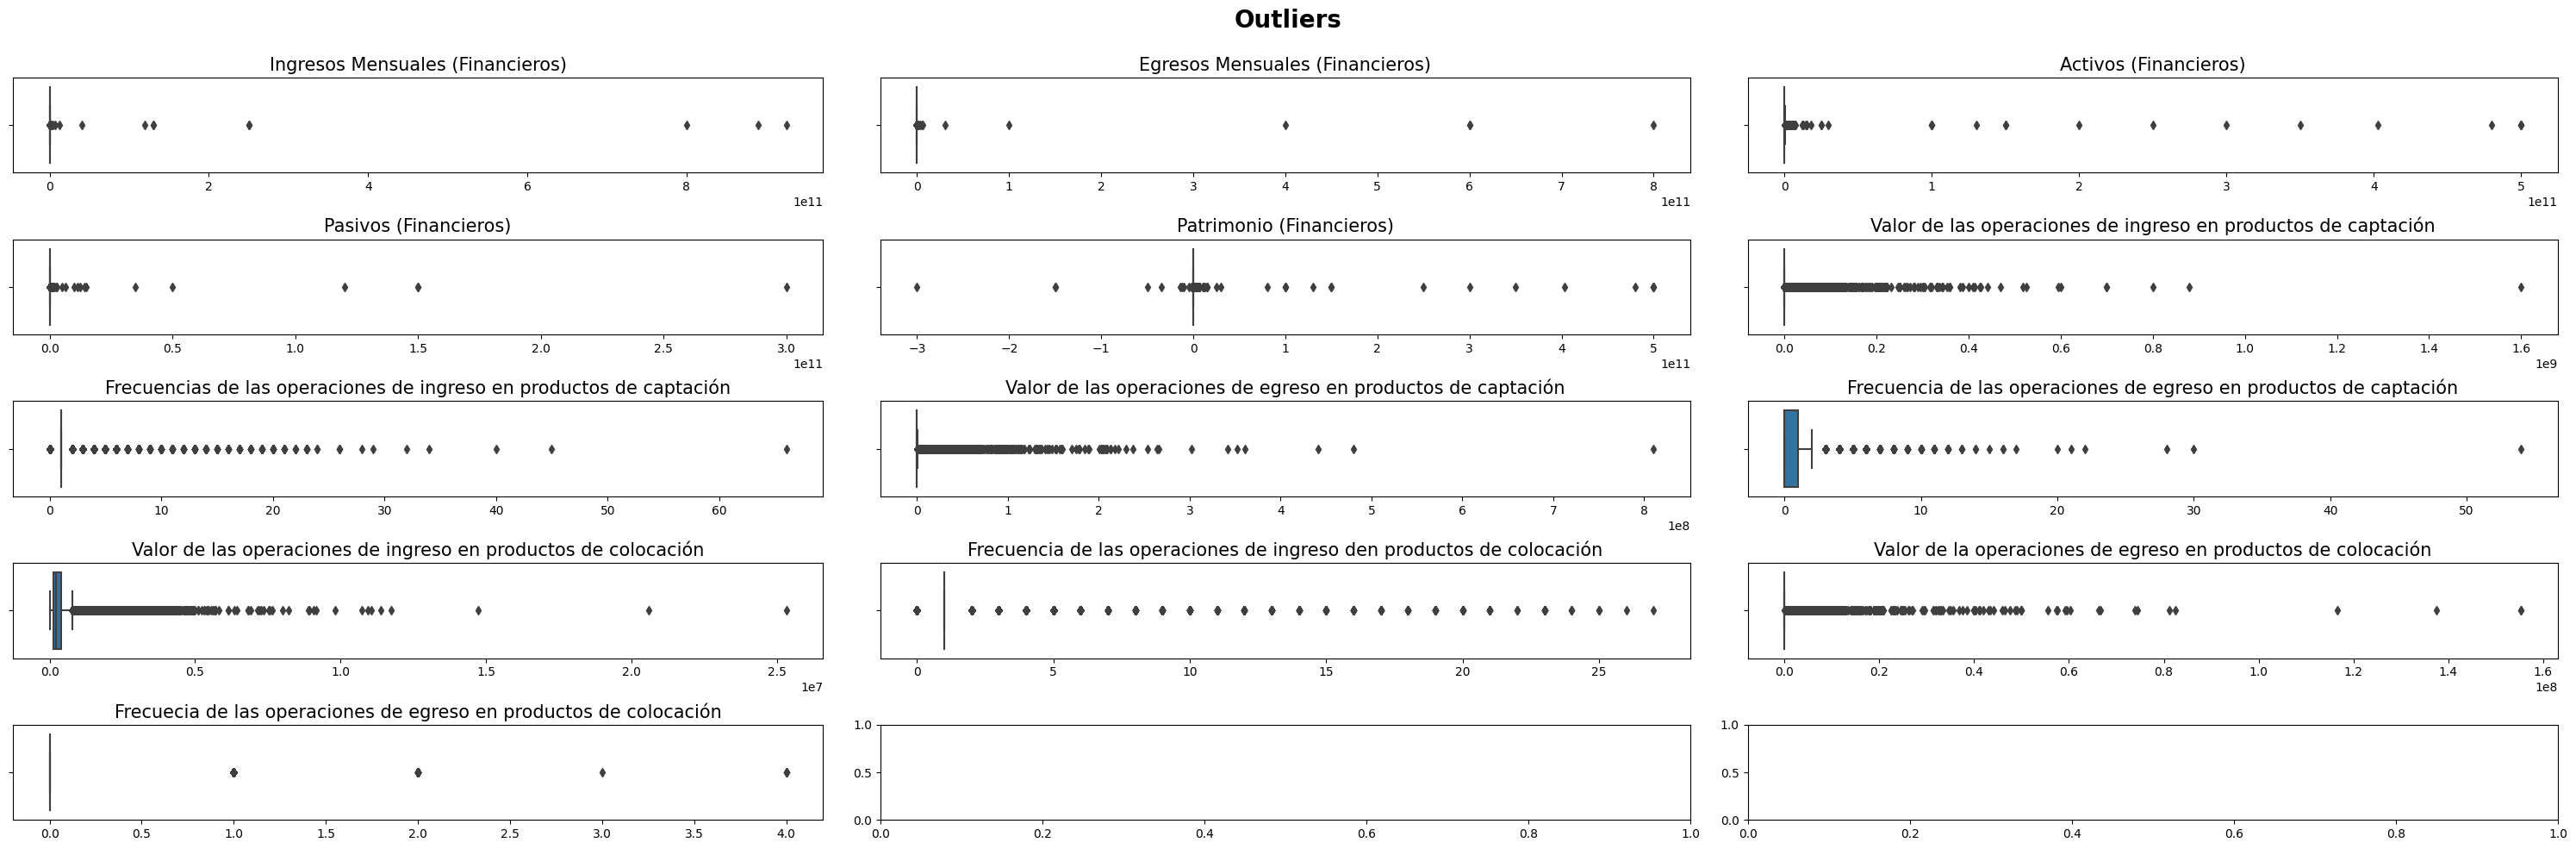

In [ ]:
plot_box(
    data,
    data_numeric,
    feature_mapping,nrows=5,
    ncols=3,
    x_size = 30,
    y_size= 10,
    font_size=15)

In [ ]:
data_box(data, data_numeric)

,Borde_Inferior,Q1,Q2,Q3,Ric,Borde_Superior,Atip_s,Atip_i,Atip_Total,Porcentaje_Atipicos
INGRESOS_MENSUALES,-2800000.00,1280000.0,2200000.0,4000000.0,2720000.0,8080000.00,28138.0,0.0,28138.0,9.964269
EGRESOS_MENSUALES,-2714999.00,700000.0,1479000.0,2976666.0,2276666.0,6391665.00,28239.0,0.0,28239.0,10.000035
ACTIVOS,-50250000.00,3900000.0,10000000.0,40000000.0,36100000.0,94150000.00,26681.0,0.0,26681.0,9.448314
PASIVOS,-10250000.00,100000.0,1855000.0,7000000.0,6900000.0,17350000.00,31779.0,0.0,31779.0,11.253625
PATRIMONIO,-41000000.00,1600000.0,6604000.0,30000000.0,28400000.0,72600000.00,31379.0,1190.0,32569.0,11.533381
CAPTACION_VALOR_CREDITO,-85478.50,11000.0,41423.0,75319.0,64319.0,171797.50,39050.0,0.0,39050.0,13.828442
CAPTACION_TRANSACCIONES_CREDITO,1.00,1.0,1.0,1.0,0.0,1.00,31350.0,58566.0,89916.0,31.841184
CAPTACION_VALOR_DEBITO,-15000.00,0.0,0.0,10000.0,10000.0,25000.00,66233.0,0.0,66233.0,23.454525
CAPTACION_TRANSACCIONES_DEBITO,-1.50,0.0,0.0,1.0,1.0,2.50,3133.0,0.0,3133.0,1.109462
COLOCACION_VALOR_CREDITO,-270750.25,121904.0,229577.0,383673.5,261769.5,776327.75,23884.0,0.0,23884.0,8.457837


In [ ]:
feature_mapping

{'INGRESOS_MENSUALES': 'Ingresos Mensuales (Financieros)',
 'EGRESOS_MENSUALES': 'Egresos Mensuales (Financieros)',
 'ACTIVOS': 'Activos (Financieros)',
 'PASIVOS': 'Pasivos (Financieros)',
 'PATRIMONIO': 'Patrimonio (Financieros)',
 'CAPTACION_VALOR_CREDITO': 'Valor de las operaciones de ingreso en productos de captación',
 'CAPTACION_TRANSACCIONES_CREDITO': 'Frecuencias de las operaciones de ingreso en productos de captación',
 'CAPTACION_VALOR_DEBITO': 'Valor de las operaciones de egreso en productos de captación',
 'CAPTACION_TRANSACCIONES_DEBITO': 'Frecuencia de las operaciones de egreso en productos de captación',
 'COLOCACION_VALOR_CREDITO': 'Valor de las operaciones de ingreso en productos de colocación',
 'COLOCACION_TRANSACCIONES_CREDITO': 'Frecuencia de las operaciones de ingreso den productos de colocación',
 'COLOCACION_VALOR_DEBITO': 'Valor de la operaciones de egreso en productos de colocación',
 'COLOCACION_TRANSACCIONES_DEBITO': 'Frecuecia de las operaciones de egreso 

In [ ]:
features = ['COLOCACION_VALOR_CREDITO', 'COLOCACION_VALOR_DEBITO']
hu = 'INGRESOS_MENSUALES'
y = minmax_scale(data[hu])
title =  f'({features[0]} vs {features[1]}) x {hu}'
cmap = getattr(cm, "plasma", cm.plasma)
X_ = data[features].values

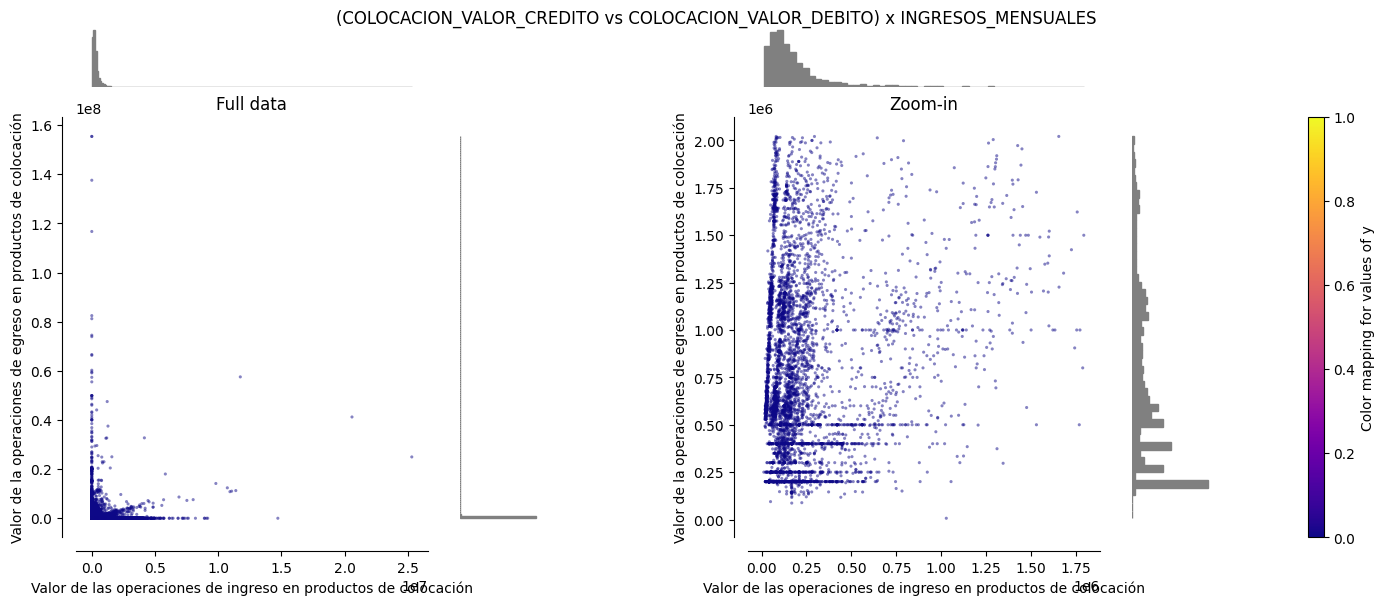

In [ ]:
make_plot(X_ , title, y, feature_mapping, features, cmap)

# **Standar Scaler**

In [ ]:
standardScaler = StandardScaler().fit_transform(X_)

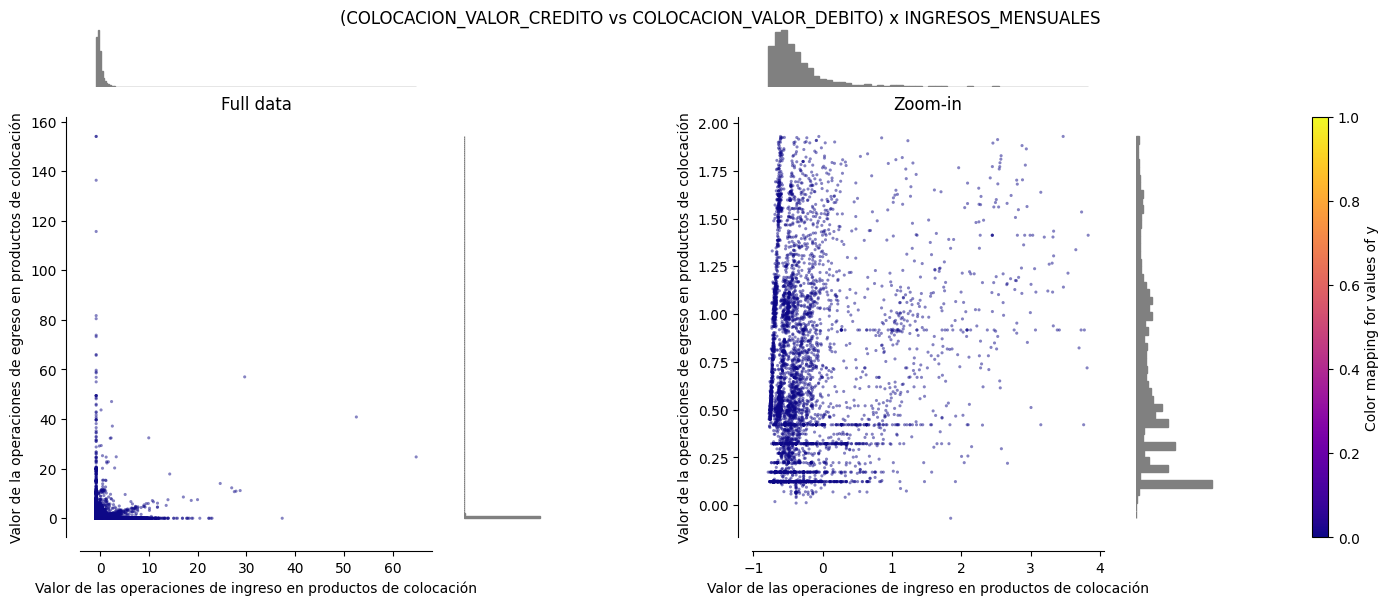

In [ ]:
make_plot(standardScaler, title, y, feature_mapping, features, cmap)

# **Min Max Scaler**

In [ ]:
minMaxScaler = MinMaxScaler().fit_transform(X_)

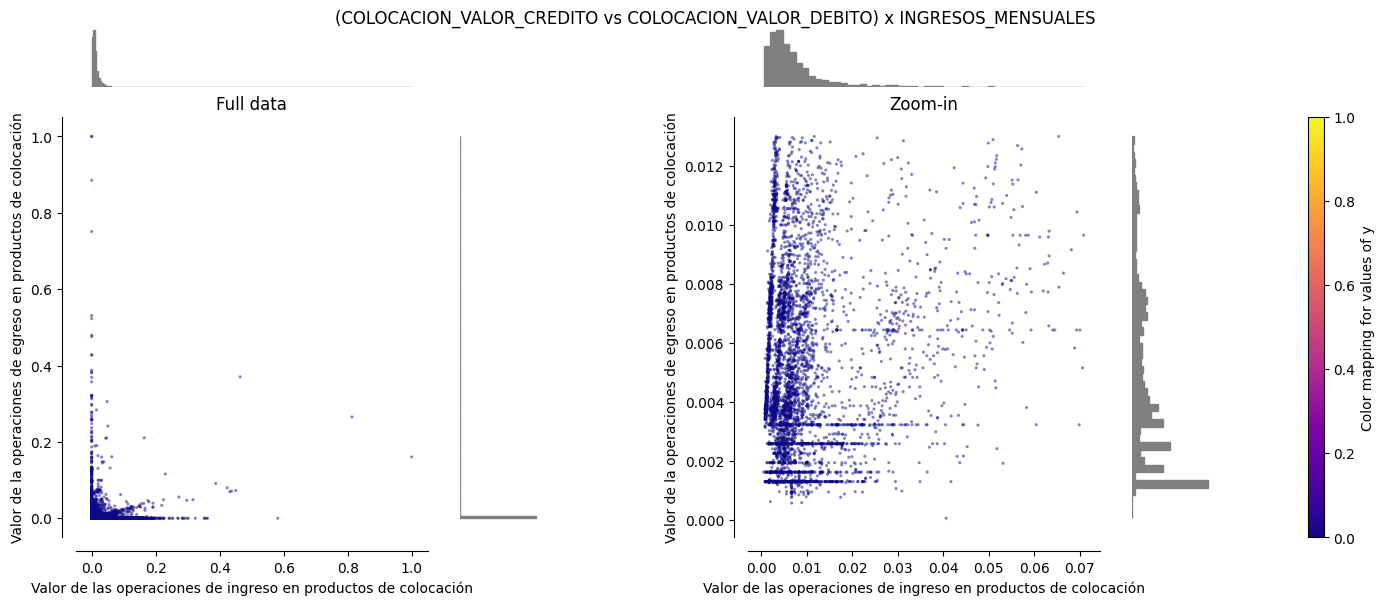

In [ ]:
make_plot(minMaxScaler, title, y, feature_mapping, features, cmap)

# **Max Abs Scaler**

In [ ]:
maxAbsScaler =  MaxAbsScaler().fit_transform(X_)

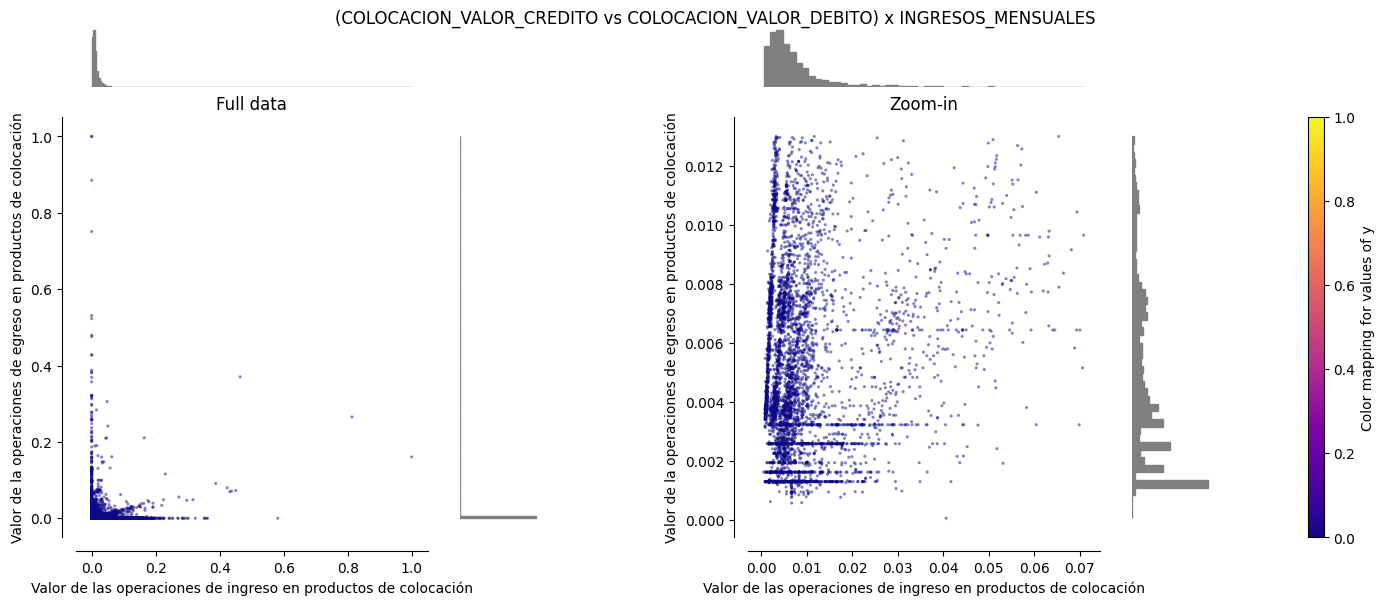

In [ ]:
make_plot(maxAbsScaler, title, y, feature_mapping, features, cmap)

# **RobustScaler**
---

In [ ]:
robust_scaler =  RobustScaler(quantile_range=(25, 75)).fit_transform(X_)

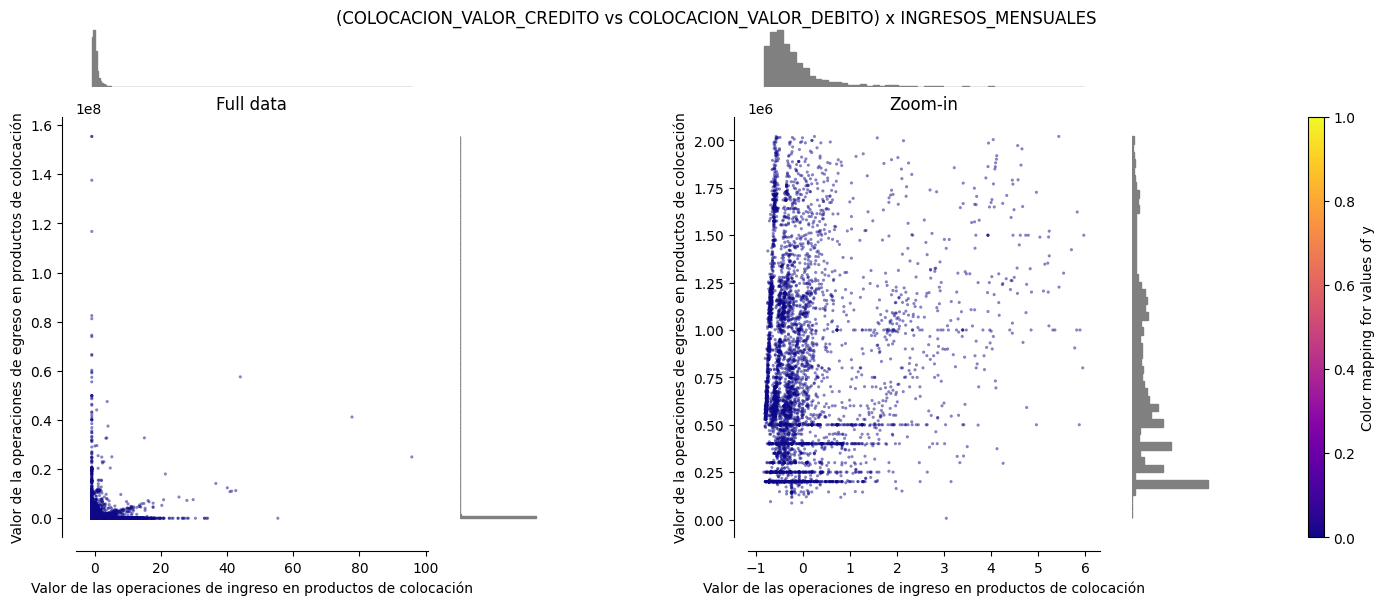

In [ ]:
make_plot(robust_scaler, title, y, feature_mapping, features, cmap)

# **PowerTransformer**
---

In [ ]:
powerTransformer =  PowerTransformer(method="yeo-johnson").fit_transform(X_)

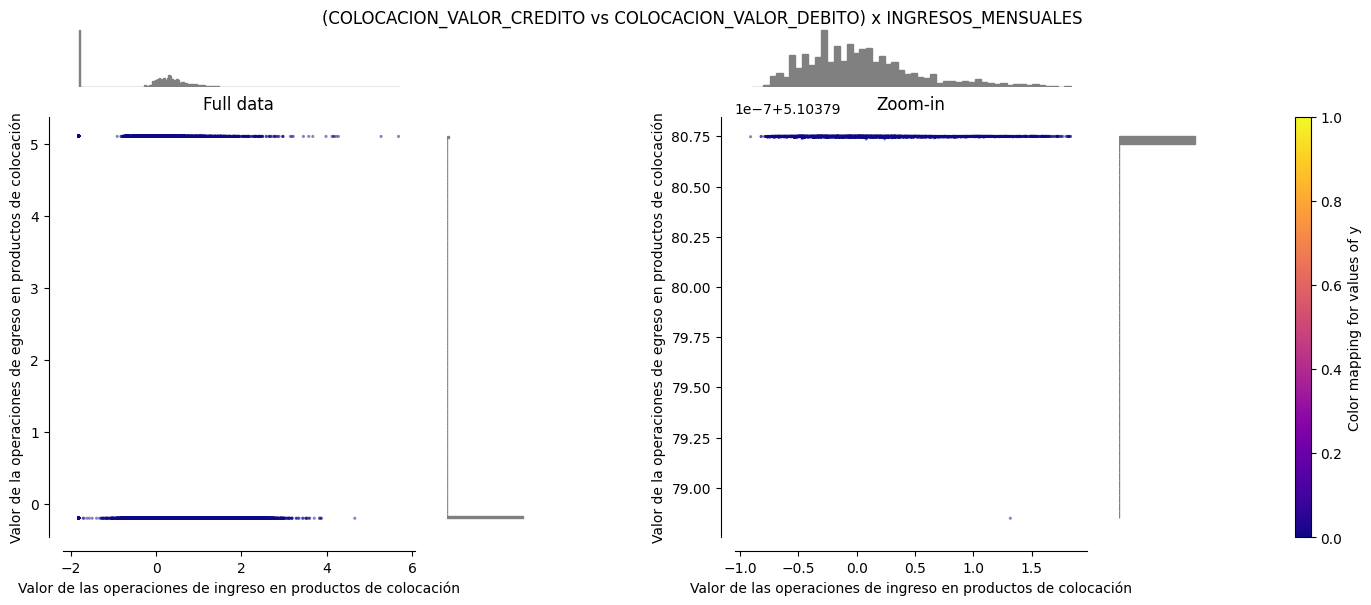

In [ ]:
make_plot(powerTransformer, title, y, feature_mapping, features, cmap)

In [ ]:
powerTransformer =  PowerTransformer(method="box-cox").fit_transform(X_)

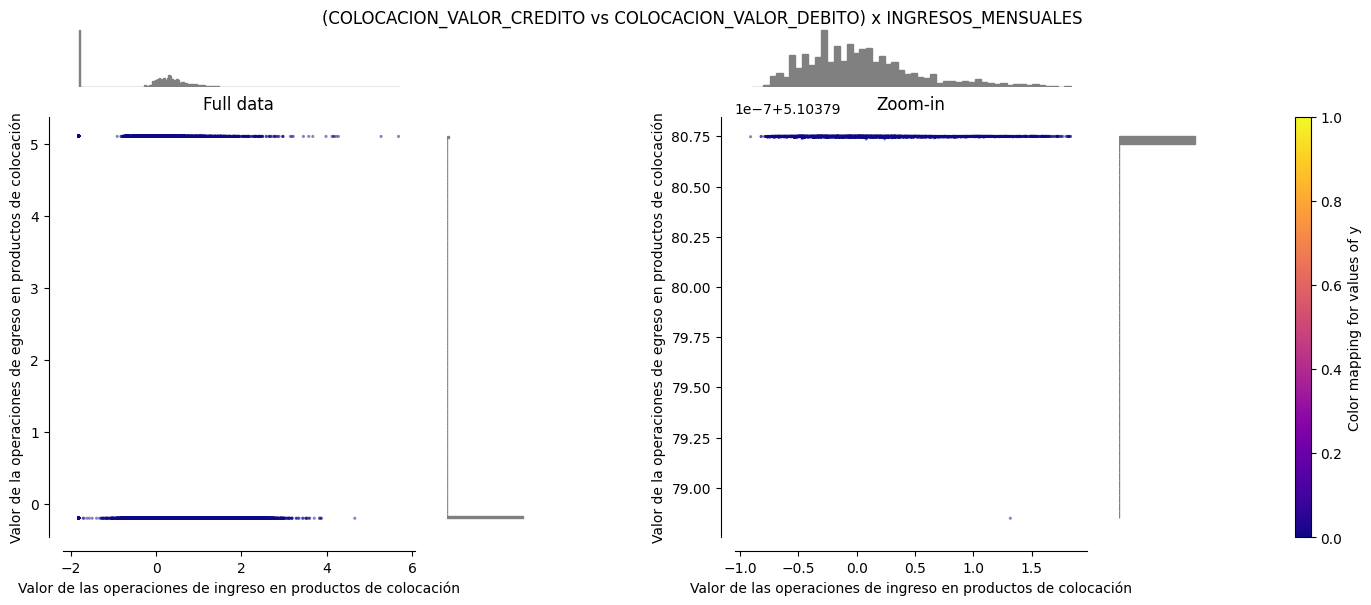

In [ ]:
make_plot(powerTransformer, title, y, feature_mapping, features, cmap)

# **QuantileTransformer**
---

In [ ]:
quantileTransformer = QuantileTransformer(output_distribution="uniform").fit_transform(X_)

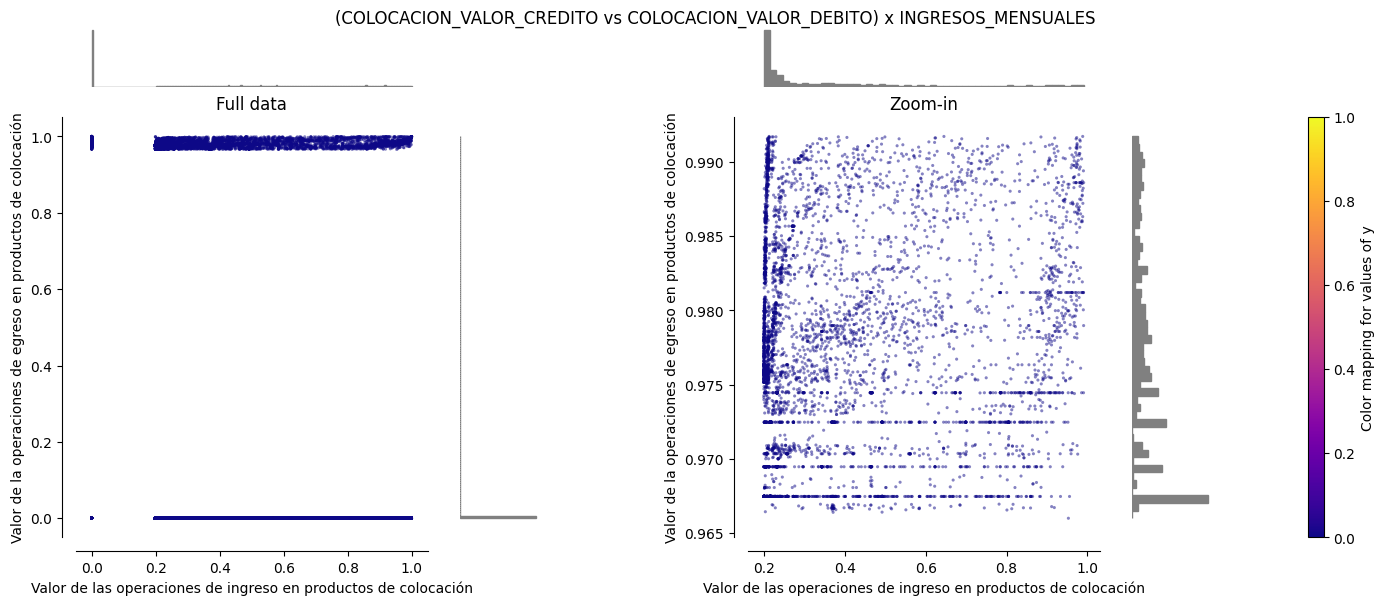

In [ ]:
make_plot(quantileTransformer, title, y, feature_mapping, features, cmap)

In [ ]:
quantileTransformer = QuantileTransformer(output_distribution="normal").fit_transform(X_)

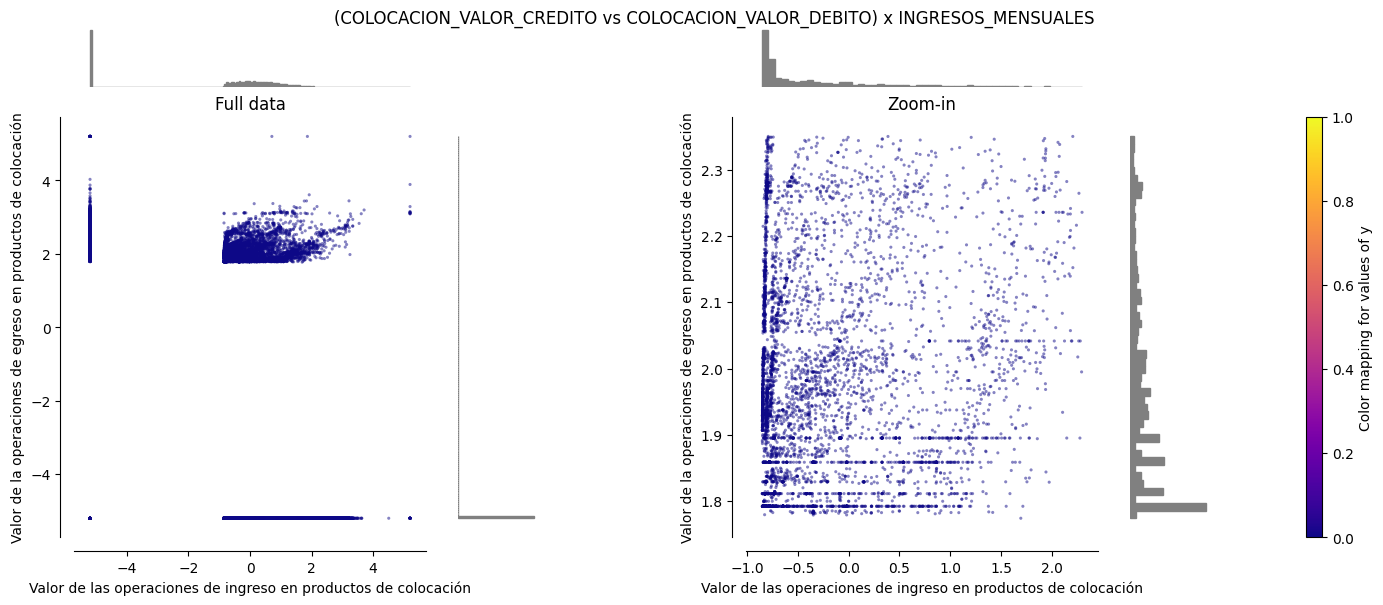

In [ ]:
make_plot(quantileTransformer, title, y, feature_mapping, features, cmap)

# **Normalización**
---

In [ ]:
normalizer = Normalizer().fit_transform(X_)

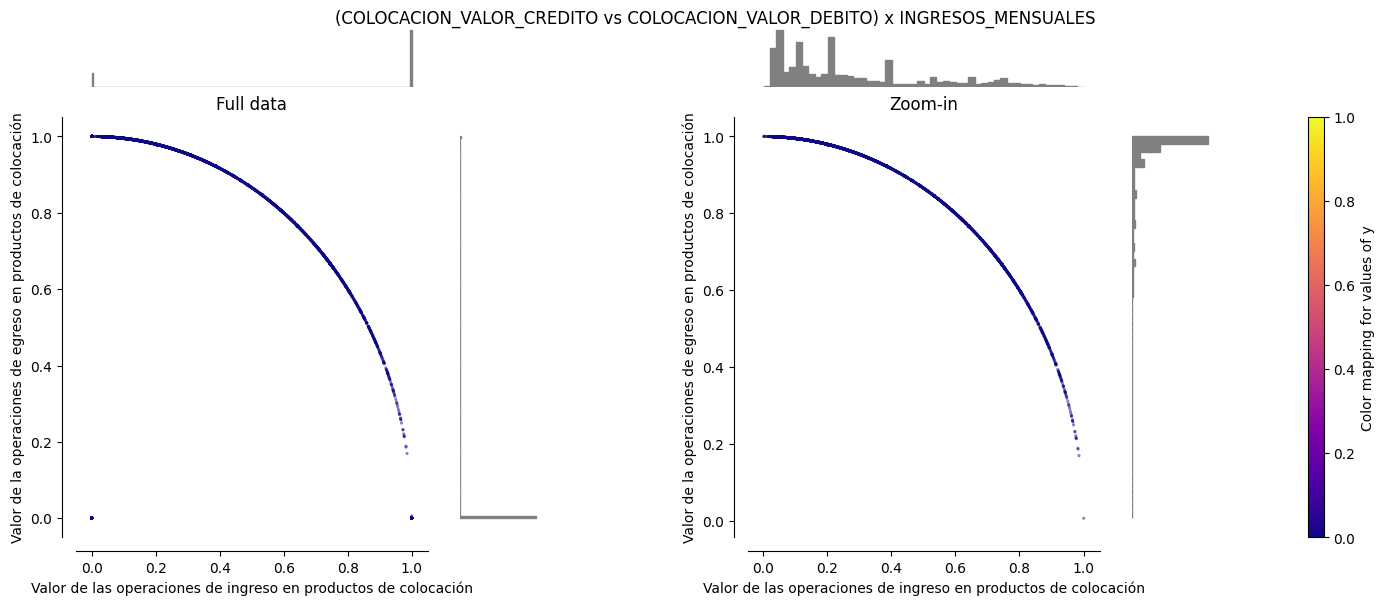

In [ ]:
make_plot(normalizer, title, y, feature_mapping, features, cmap)

----

El set de datos SaratogaHouses del paquete mosaicData de R contiene información sobre el precio de 1728 viviendas situadas en Saratoga County, New York, USA en el año 2006. Además del precio, incluye 15 variables adicionales

In [ ]:
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/master/data/SaratogaHouses.csv'
data = pd.read_csv(url)
data

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
0,132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No
1,181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No
2,109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No
3,155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No
4,86060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,No,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,289000,0.38,32,24200,2310,61,5,1,2.5,11,hot water/steam,gas,public/commercial,No,No,No
1724,285000,0.94,37,36200,2564,61,4,1,2.5,11,hot water/steam,gas,public/commercial,No,No,No
1725,194900,0.39,9,20400,1099,51,2,0,1.0,3,hot air,gas,public/commercial,No,No,No
1726,125000,0.24,48,16800,1225,51,3,1,1.0,7,hot air,gas,public/commercial,No,No,No


In [ ]:
data.columns

Index(['price', 'lotSize', 'age', 'landValue', 'livingArea', 'pctCollege',
       'bedrooms', 'fireplaces', 'bathrooms', 'rooms', 'heating', 'fuel',
       'sewer', 'waterfront', 'newConstruction', 'centralAir'],
      dtype='object')

In [ ]:
data_numeric, data_object, message = type_data_feature(data)
message

' Contamos con 10 características\n  cuantitativas y 6 categoricas '

In [ ]:
data_numeric

['price',
 'lotSize',
 'age',
 'landValue',
 'livingArea',
 'pctCollege',
 'bedrooms',
 'fireplaces',
 'bathrooms',
 'rooms']

In [ ]:
data_numeric_context = [
  'precio de la vivienda.',
  'metros cuadrados de la vivienda.',
  'antigüedad de la vivienda.',
  'valor del terreno.',
  'metros cuadrados habitables.',
  'porcentaje del vecindario con título universitario.',
  'número de dormitorios.',
  'número de chimeneas.',
  'número de cuartos de baño (el valor 0.5 hace referencia a cuartos de baño sin ducha).',
  'número de habitaciones'
]

In [ ]:
feature_mapping = create_dict_data(data_numeric, data_numeric_context)
feature_mapping

{'price': 'precio de la vivienda.',
 'lotSize': 'metros cuadrados de la vivienda.',
 'age': 'antigüedad de la vivienda.',
 'landValue': 'valor del terreno.',
 'livingArea': 'metros cuadrados habitables.',
 'pctCollege': 'porcentaje del vecindario con título universitario.',
 'bedrooms': 'número de dormitorios.',
 'fireplaces': 'número de chimeneas.',
 'bathrooms': 'número de cuartos de baño (el valor 0.5 hace referencia a cuartos de baño sin ducha).',
 'rooms': 'número de habitaciones'}

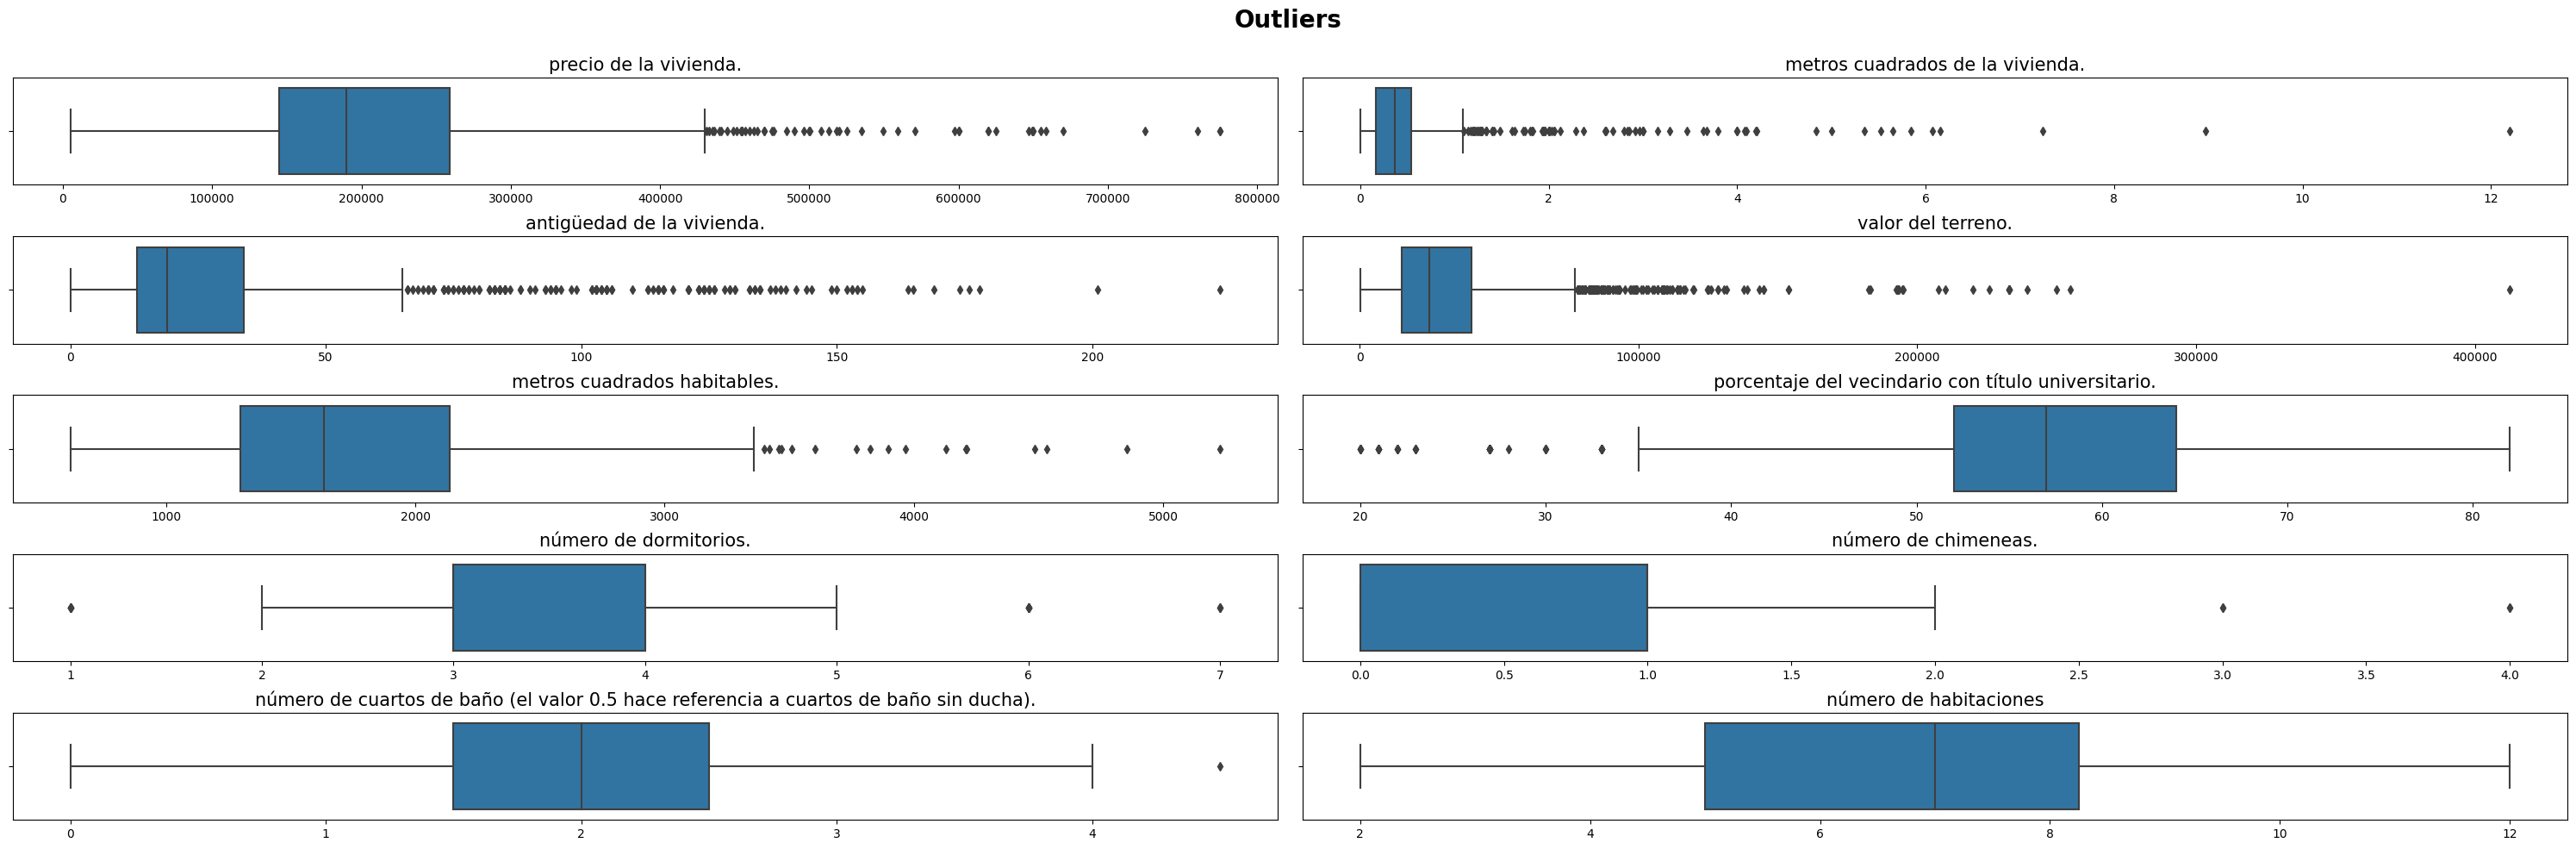

In [ ]:
plot_box(
    data,
    data_numeric,
    feature_mapping,
    nrows=5,
    ncols=2,
    x_size = 30,
    y_size= 10,
    font_size=15)

In [ ]:
data_box(data, data_numeric)

,Borde_Inferior,Q1,Q2,Q3,Ric,Borde_Superior,Atip_s,Atip_i,Atip_Total,Porcentaje_Atipicos
price,-26000.000,145000.00,189900.00,259000.00,114000.00,430000.000,53.0,0.0,53.0,3.067130
lotSize,-0.385,0.17,0.37,0.54,0.37,1.095,80.0,0.0,80.0,4.629630
age,-18.500,13.00,19.00,34.00,21.00,65.500,148.0,0.0,148.0,8.564815
landValue,-22550.000,15100.00,25000.00,40200.00,25100.00,77850.000,166.0,0.0,166.0,9.606481
livingArea,43.375,1300.00,1634.50,2137.75,837.75,3394.375,17.0,0.0,17.0,0.983796
pctCollege,34.000,52.00,57.00,64.00,12.00,82.000,0.0,41.0,41.0,2.372685
bedrooms,1.500,3.00,3.00,4.00,1.00,5.500,11.0,7.0,18.0,1.041667
fireplaces,-1.500,0.00,1.00,1.00,1.00,2.500,4.0,0.0,4.0,0.231481
bathrooms,0.000,1.50,2.00,2.50,1.00,4.000,1.0,0.0,1.0,0.057870
rooms,0.125,5.00,7.00,8.25,3.25,13.125,0.0,0.0,0.0,0.000000


In [ ]:
features = ['price', 'landValue']
hu = 'age'
y = minmax_scale(data[hu])
title =  f'({features[0]} vs {features[1]}) x {hu}'
cmap = getattr(cm, "plasma_r", cm.plasma_r)
X_ = data[features].values

In [ ]:
data[hu]

0        42
1         0
2       133
3        13
4         0
       ... 
1723     32
1724     37
1725      9
1726     48
1727     86
Name: age, Length: 1728, dtype: int64

In [ ]:
y

array([0.18666667, 0.        , 0.59111111, ..., 0.04      , 0.21333333,
       0.38222222])

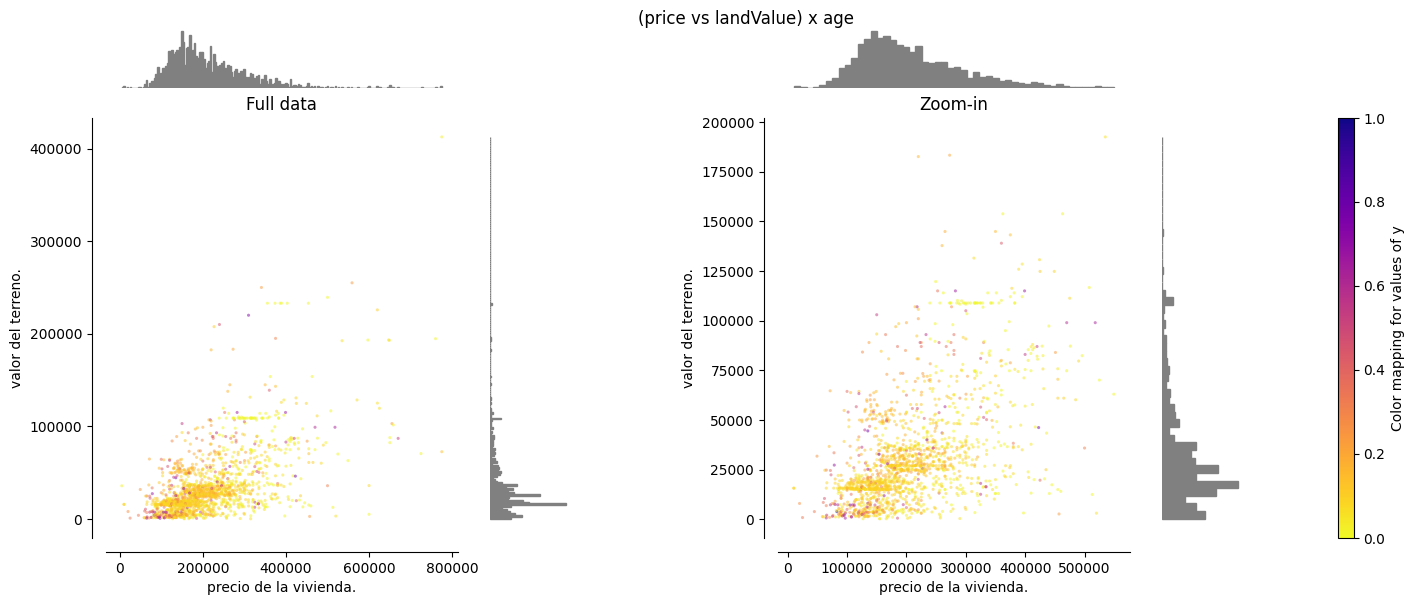

In [ ]:
make_plot(X_ , title, y, feature_mapping, features, cmap)

# **Standar Scaler**

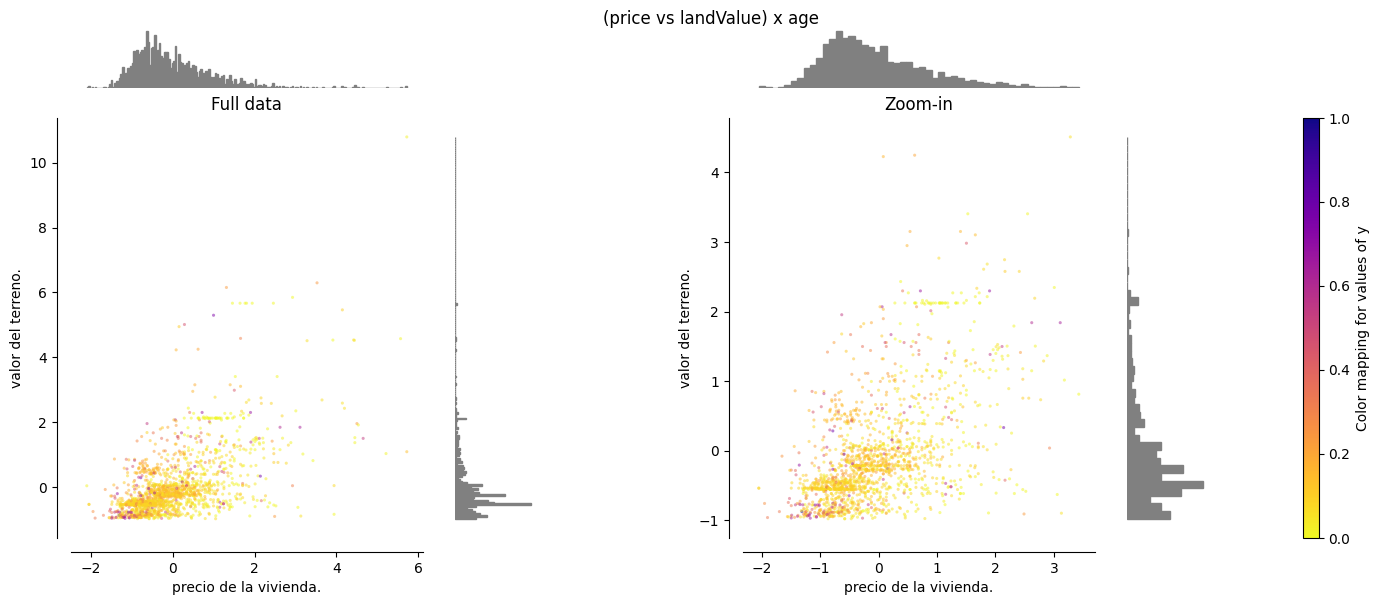

In [ ]:
standardScaler = StandardScaler().fit_transform(X_)
make_plot(standardScaler, title, y, feature_mapping, features, cmap)

# **Min Max Scaler**

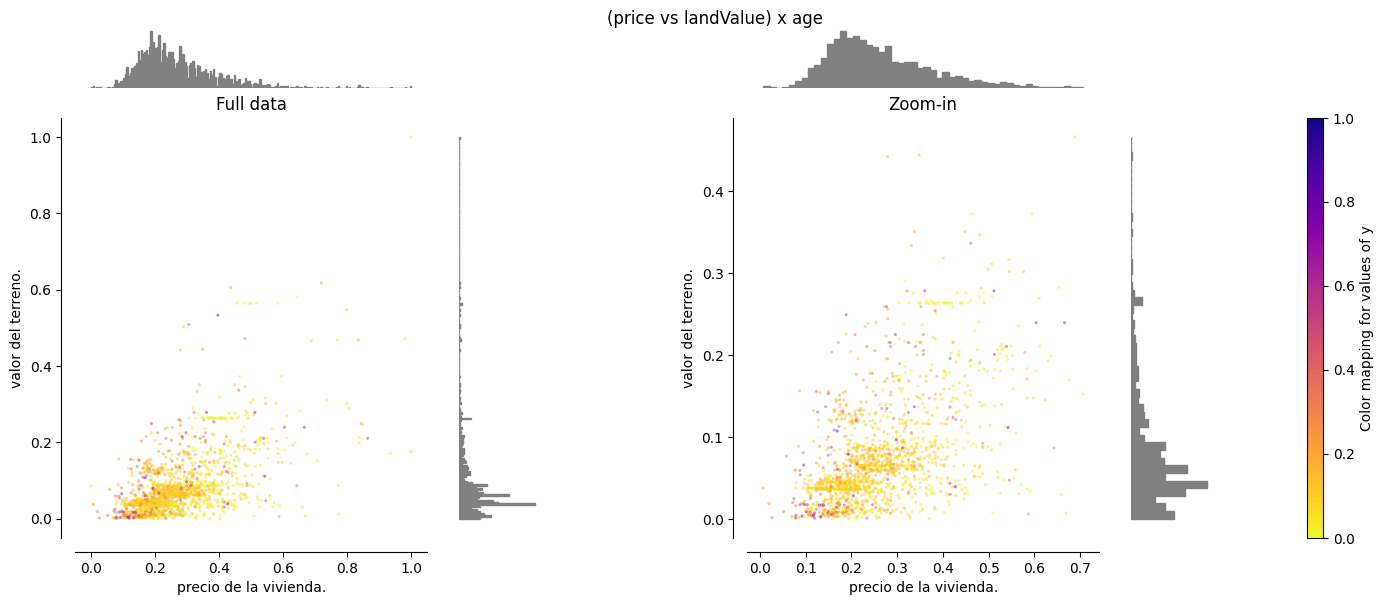

In [ ]:
minMaxScaler = MinMaxScaler().fit_transform(X_)
make_plot(minMaxScaler, title, y, feature_mapping, features, cmap)

# **Max Abs Scaler**

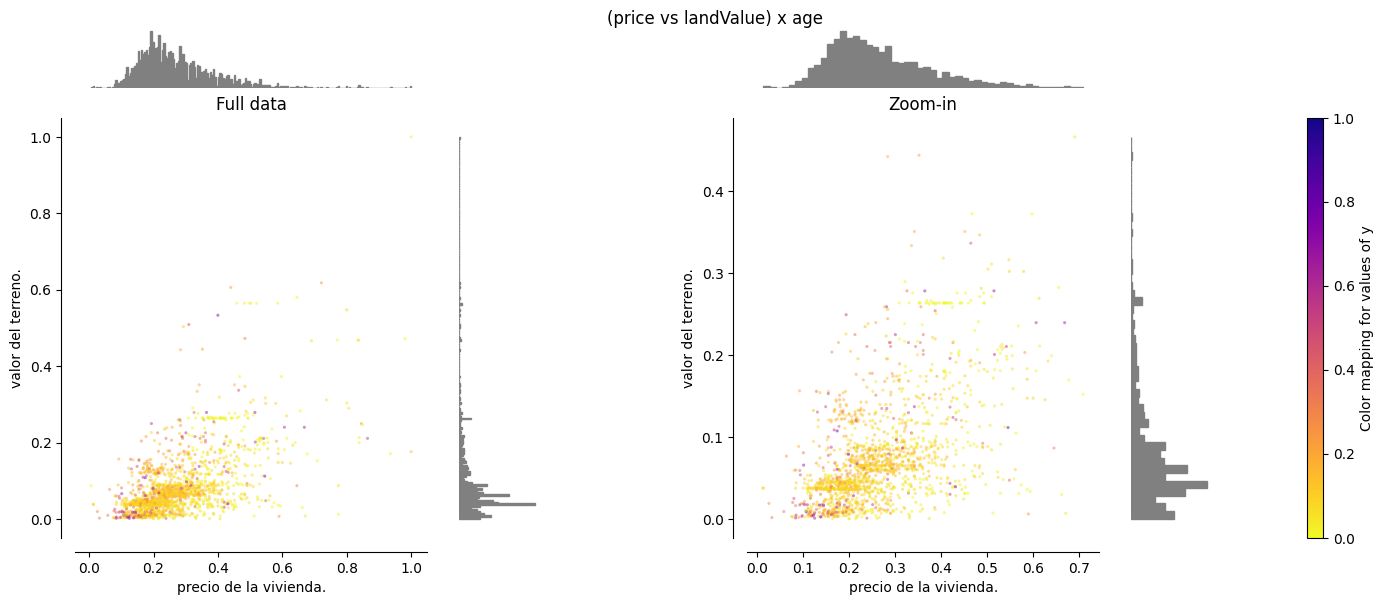

In [ ]:
maxAbsScaler =  MaxAbsScaler().fit_transform(X_)
make_plot(maxAbsScaler, title, y, feature_mapping, features, cmap)

# **RobustScaler**


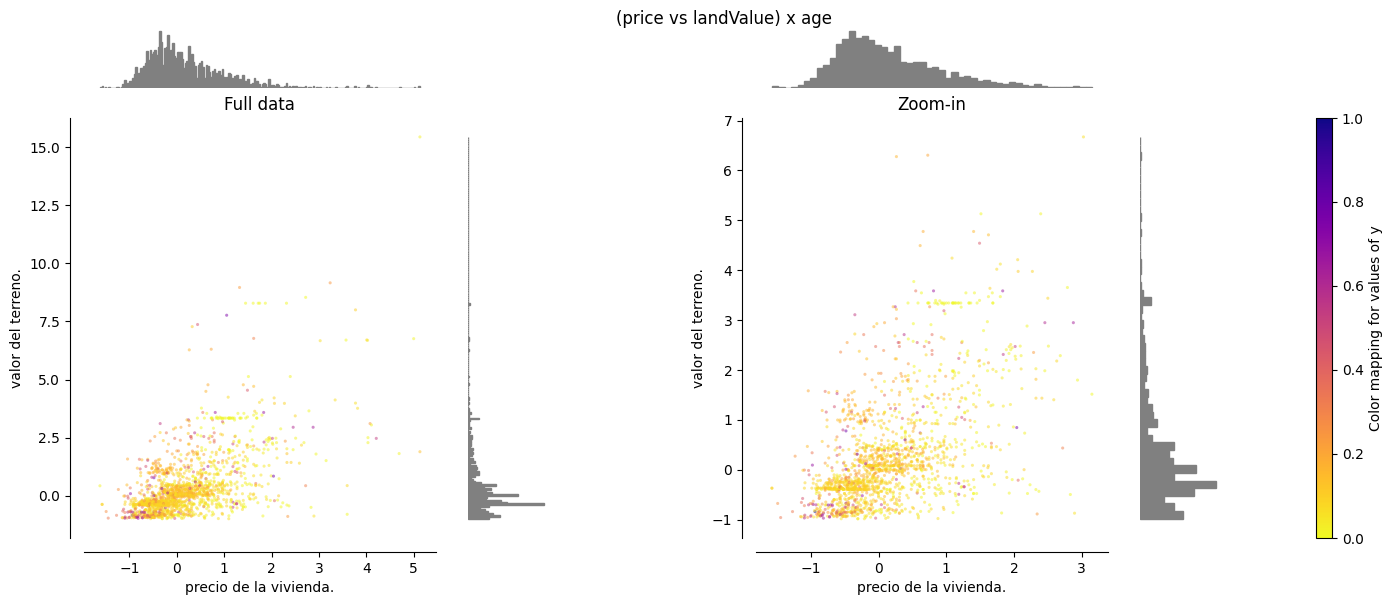

In [ ]:
robust_scaler =  RobustScaler(quantile_range=(25, 75)).fit_transform(X_)
make_plot(robust_scaler, title, y, feature_mapping, features, cmap)

# **PowerTransformer**
---

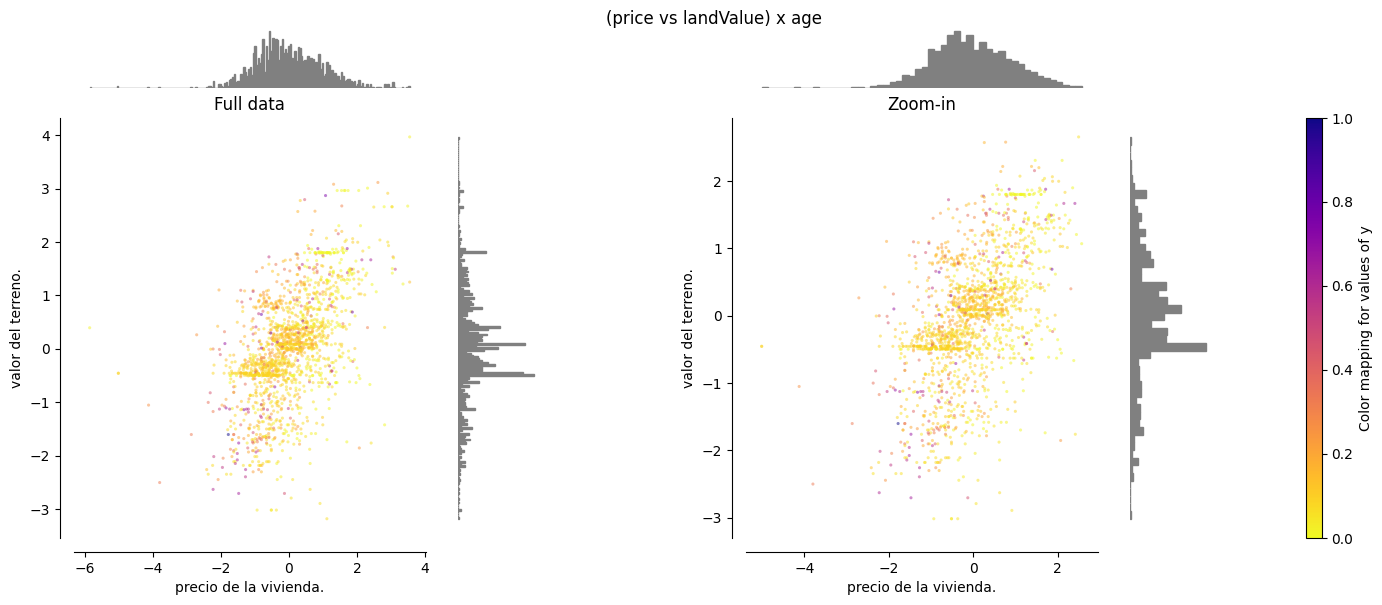

In [ ]:
powerTransformer =  PowerTransformer(method="yeo-johnson").fit_transform(X_)
make_plot(powerTransformer, title, y, feature_mapping, features, cmap)

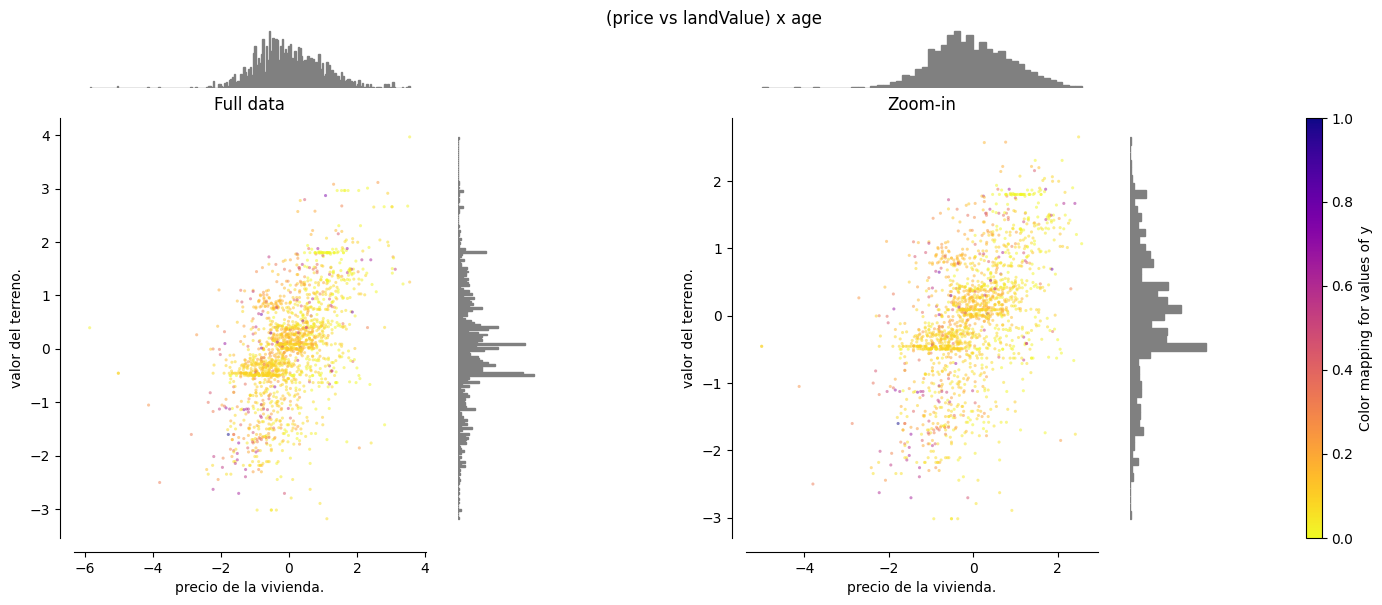

In [ ]:
powerTransformer =  PowerTransformer(method="box-cox").fit_transform(X_)
make_plot(powerTransformer, title, y, feature_mapping, features, cmap)

# **QuantileTransformer**
---

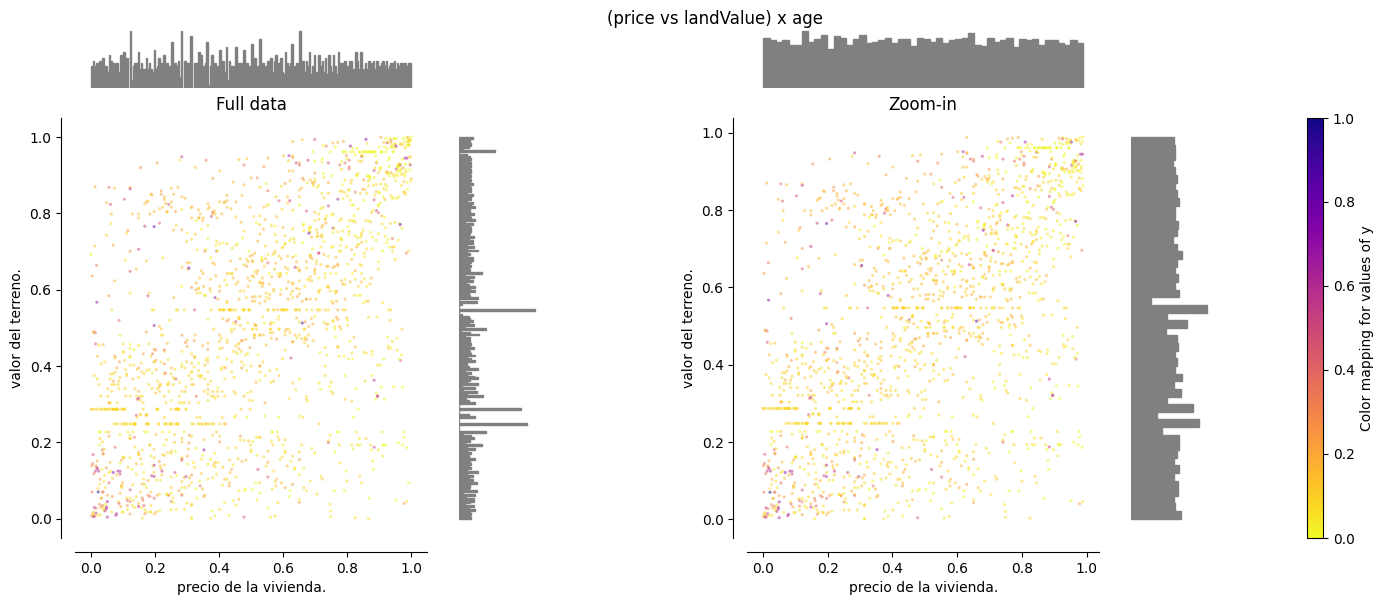

In [ ]:
quantileTransformer = QuantileTransformer(output_distribution="uniform").fit_transform(X_)
make_plot(quantileTransformer, title, y, feature_mapping, features, cmap)

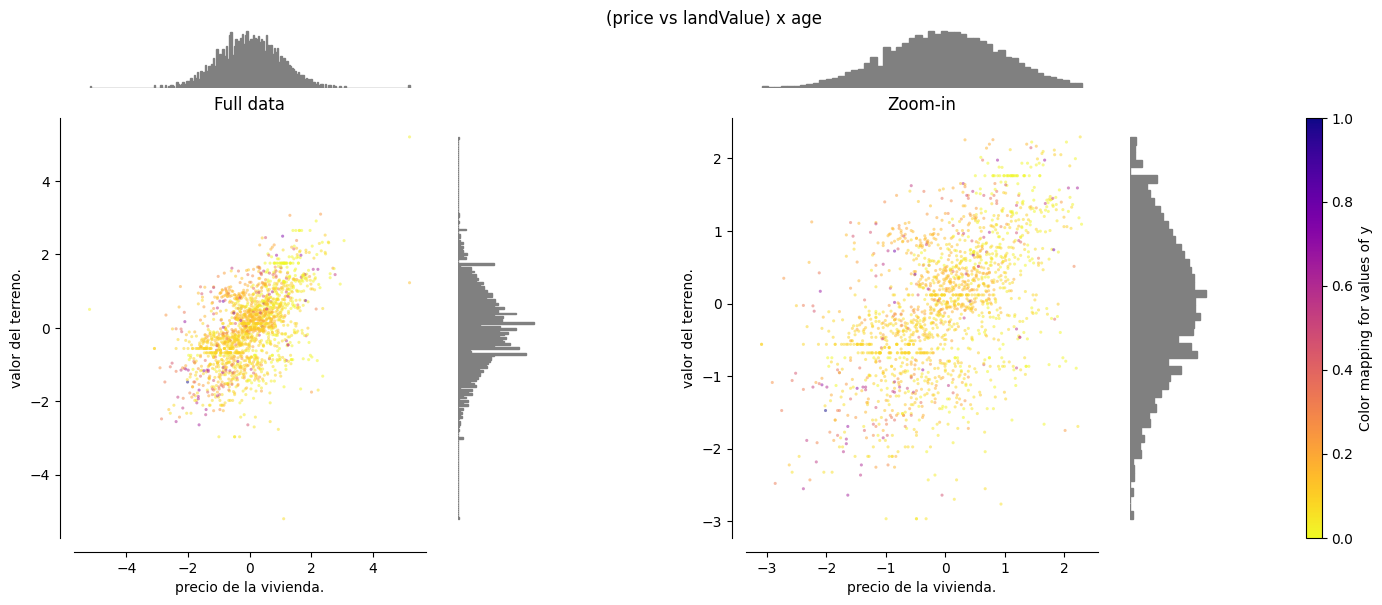

In [ ]:
quantileTransformer = QuantileTransformer(output_distribution="normal").fit_transform(X_)
make_plot(quantileTransformer, title, y, feature_mapping, features, cmap)

# **Normalización**
---

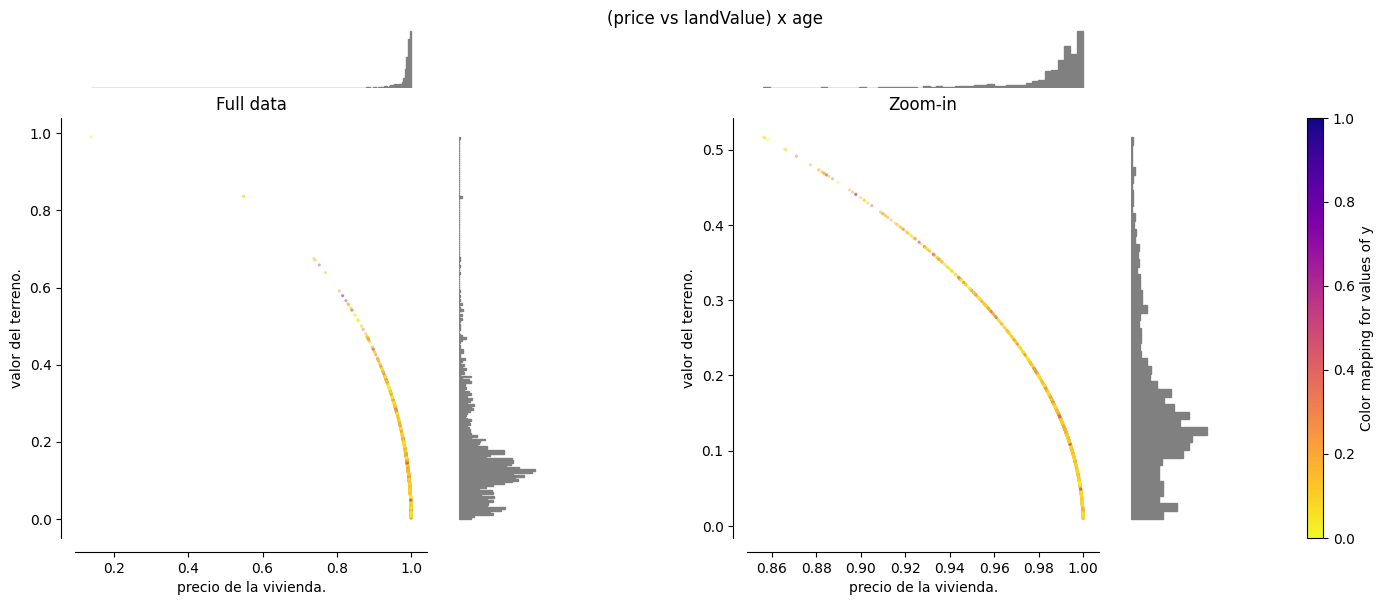

In [ ]:
 normalizer = Normalizer().fit_transform(X_)
 make_plot(normalizer, title, y, feature_mapping, features, cmap)

# **Referencia**
---
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py